In [1]:
import cdsapi
import os
import ssl
import warnings
from pathlib import Path
from tqdm import tqdm

import warnings
import netCDF4
from netCDF4 import num2date
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
import rasterio as rio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds


# Suppress all warnings
warnings.filterwarnings("ignore")


from sqlalchemy import create_engine, text
import pandas as pd

# Append the pyquacache path
sys.path.append(str(Path().resolve().parent))
import pyquacache.utils.queries as pqc
from pyquacache.defs.config import db_url_prod as db_url

# Download drainage basin boundaries
gdf = pqc.fetch_drainage_basin_boundaries()


data_dir = Path(".data")



In [2]:
gdf

,geom_id,geom_type,layer_name,description,geom,geometry
feature_name,,,,,,
08AA003,1,ST_Polygon,Drainage basins,DEZADEASH RIVER AT HAINES JUNCTION,0103000020AD10000001000000594B0000CCA2E96AA10E...,"POLYGON ((-136.4572 60.14162, -136.45856 60.14..."
08AA005,7,ST_Polygon,Drainage basins,AISHIHIK LAKE NEAR WHITEHORSE,0103000020AD100000010000006D26000047B0FF0F1422...,"POLYGON ((-137.06495 61.14286, -137.06588 61.1..."
08AA007,8,ST_Polygon,Drainage basins,SEKULMUN LAKE NEAR WHITEHORSE,0103000020AD1000000200000043180000FF414574FA2F...,"POLYGON ((-137.49932 61.48734, -137.49886 61.4..."
08AA008,9,ST_Polygon,Drainage basins,SEKULMUN RIVER AT OUTLET OF SEKULMUN LAKE,0103000020AD10000002000000FF170000FF414574FA2F...,"POLYGON ((-137.49932 61.48734, -137.49886 61.4..."
08AA009,10,ST_Polygon,Drainage basins,GILTANA CREEK NEAR THE MOUTH,0103000020AD10000001000000B30800008566D8E6CC18...,"POLYGON ((-136.77501 61.32439, -136.77641 61.3..."
...,...,...,...,...,...,...
29CA004,2109,ST_Polygon,Drainage basins,Quill Creek,0103000020AD10000001000000990500002BB1D13D0E72...,"POLYGON ((-139.56424 61.44901, -139.56438 61.4..."
29CA005,2110,ST_Polygon,Drainage basins,Christmas Creek,0103000020AD10000001000000F50500008D0999C69649...,"POLYGON ((-138.29966 60.92043, -138.29979 60.9..."
29CB007,2111,ST_Polygon,Drainage basins,Koidern River,0103000020AD10000001000000AD0F00001C87E0D1BE8F...,"POLYGON ((-140.49204 61.75094, -140.4921 61.75..."


In [ ]:
import era5utils as era5

#era5.download_from_cds(
#    years=[2024, 2025]
#)




  0%|          | 0/2 [00:00<?, ?it/s]

File .data\raw\era5_reanalysis_snow_2024-01.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-02.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-03.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-04.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-05.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-06.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-07.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-08.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-09.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-10.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-11.zip already exists. Skipping download.
File .data\raw\era5_reanalysis_snow_2024-12.zip already exists. Skipping download.
File

2025-04-09 16:37:54,780 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-09 16:37:54,780 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-09 16:37:55,970 INFO Request ID is d10ee09f-9865-454c-aded-f4c5121521bb
2025-04-09 16:37:56,306 INFO status has been updated to accepted
 50%|█████     | 1/2 [00:05<00:05,  5.75s/it]


KeyboardInterrupt: 

In [6]:
era5.zip_to_nc(source_dir=data_dir/"raw", destination_dir=data_dir/"extracted")
xda = era5.concatenate_to_xda(
    data_dir/"extracted",
    param="sd", 
    freq="daily",
    resampling_function="mean"
    )
xda.values = xda.values * 1000 # Convert from m to mm
xda.attrs["units"] = "mm"


Unzipping files: 304it [00:03, 86.68it/s] 


In [7]:
xda["time"] = pd.to_datetime(xda["time"].values)

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29',
               '2025-03-30', '2025-03-31', '2025-04-01', '2025-04-02',
               '2025-04-03', '2025-04-04'],
              dtype='datetime64[ns]', length=9226, freq=None)

In [ ]:
xda

In [80]:

# resample to monthly
xda_monthly = xda.resample(time="1M").mean()

# by default, monthly means are taken at the end of the month, so we need to shift them to the start of the month
xda_monthly["time"] = pd.to_datetime(xda_monthly["time"].values) + pd.DateOffset(days=1)


historic_monthly_mean = xda_monthly.groupby("time.month").mean(dim="time", skipna=True)
historic_monthly_max = xda_monthly.groupby("time.month").max(dim="time", skipna=True)
historic_monthly_min = xda_monthly.groupby("time.month").min(dim="time", skipna=True)
historic_monthly_std = xda_monthly.groupby("time.month").std(dim="time", skipna=True)
historic_monthly_med = xda_monthly.groupby("time.month").median(dim="time", skipna=True)

xda_daily = xda.resample(time="1D").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values, utc=True)
historic_yearly_mean =  xda_monthly.groupby("time.day").mean(dim="time", skipna=True)

#deviation_from_norm = deviation_from_norm.clip(min=-200, max=200)


In [84]:
xda_daily = xda.resample(time="1d").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values)

start_hist = "2000-01-01"
end_hist = "2020-12-31"
historic_yearly_mean =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").mean(dim="time", skipna=True)
historic_yearly_med =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").median(dim="time", skipna=True)
historic_yearly_max =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").max(dim="time", skipna=True)
historic_yearly_min =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").min(dim="time", skipna=True)


<xarray.DataArray 'sd' (latitude: 222, longitude: 301)> Size: 267kB
array([[      nan,       nan,       nan, ..., 205.71454, 222.16731,
        235.7048 ],
       [      nan,       nan,       nan, ..., 154.84502, 169.45865,
        191.86107],
       [      nan,       nan,       nan, ..., 140.14842, 147.10393,
        163.17957],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 2kB 50.0 50.1 50.2 50.3 ... 71.8 71.9 72.0
  * longitude  (longitude) float64 2kB -150.0 -149.9 -149.8 ... -120.1 -120.0
    month      int64 8B 4
Attributes:
    count:                 {54: 41}
    name:                  {54: 'Snow depth'}
    units:                 mm
    Variable name in CDS:  {54: 'snow_depth'}
    shortName:             {54: 'sd'}
    ParamId:               {54: 141}
    an:                    {54: 'x'}
    fc:                    {54: 'x'}

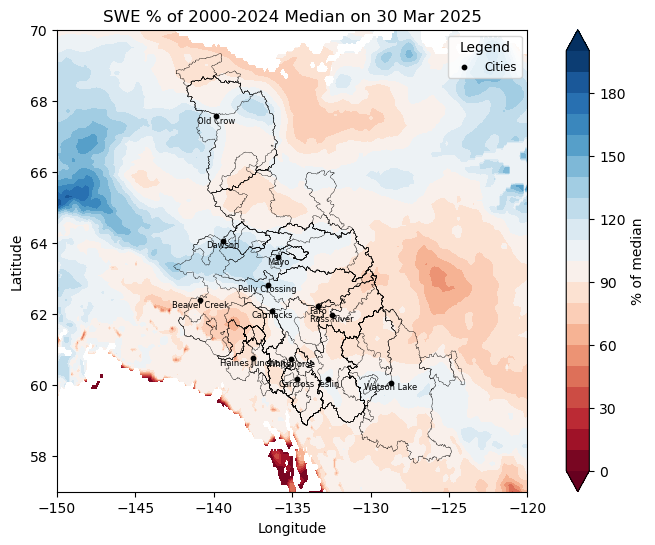

In [ ]:


from datetime import datetime, timedelta
from pathlib import Path

# Example: Convert day of year 100 in the year 2025 to a datetime
year = 20
doy = 89
query_datetime = pd.Timestamp(datetime(2025, 1, 1) + timedelta(days=doy - 1))
historic_data = historic_yearly_mean.sel(dayofyear=doy)
data = xda_daily.sel(time=query_datetime, method="nearest")

deviation_from_norm = 100 * (data) / historic_data


fig, ax = plt.subplots(figsize=(10, 6))

# Create a contour plot for deviation_from_norm
contour = ax.contourf(
    deviation_from_norm.longitude,
    deviation_from_norm.latitude,
    deviation_from_norm.values,
    levels=np.linspace(0, 200, 21),  # Levels centered around 0
    cmap="RdBu",  # Red-White-Blue colormap
    extend='both'
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, extend='both')
cbar.set_label(r"% of median")

# Add labels and title
ax.set_title(f"SWE % of 2000-2024 Median on {query_datetime.strftime('%d %b %Y')}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

gdf.plot(ax=ax, color="None", edgecolor="black", label='Locations', linewidth=0.2)

# Add cities to the map
cities = gpd.read_file(".data/shapes/cgn_yt_shp_eng.zip", crs="EPSG:4326")
cities = cities[(cities.CATEGORY == "Populated Place") & (cities.REL_SCALE.astype(int) > 3000000)]
for idx, row in cities.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y, row.GEONAME,
        fontsize=6, color='black', ha='center', va='top'
    )
# Plot cities on the map
cities.plot(ax=ax, color='black', markersize=10, label='Cities')

# Update legend
ax.legend(loc='upper right', fontsize='small', title='Legend')

plt.ylim(57,70)
plt.show()


In [79]:
xda_monthly.time

<xarray.DataArray 'time' (time: 304)> Size: 2kB
array(['2000-02-29T00:00:00.000000000', '2000-03-29T00:00:00.000000000',
       '2000-04-30T00:00:00.000000000', ..., '2025-03-28T00:00:00.000000000',
       '2025-04-30T00:00:00.000000000', '2025-05-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-02-29 2000-03-29 ... 2025-05-30

In [81]:
# Create an interactive slider with a bigger bar
month_slider = IntSlider(
    min=0, 
    max=len(xda_monthly.time) - 1, 
    step=1, 
    value=0, 
    description="Month Index",
    style={'description_width': 'initial'},  # Adjust description width
    layout={'width': '600px'}  # Increase slider width
)

# Use the interact function to link the slider to the plot function
interact(plot_xda_monthly, month_index=month_slider)


interactive(children=(IntSlider(value=0, description='Month Index', layout=Layout(width='600px'), max=303, sty…

<function __main__.plot_xda_monthly(month_index)>

In [54]:
cities.REL_SCALE.astype(int) > 500

0       True
1       True
2       True
3       True
4       True
        ... 
4014    True
4015    True
4016    True
4017    True
4018    True
Name: REL_SCALE, Length: 4019, dtype: bool

In [7]:

def plot_xda_time(time_index):
    """
    Plot the xda data for a specific time index.
    """
    plt.figure(figsize=(10, 6))
    xda.sel(time=xda.time[time_index], method="nearest").plot(cmap="viridis", vmin=0, vmax=500)
    plt.title(f"Snow Depth on {str(xda.time[time_index].values)}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Create an interactive slider
time_slider = IntSlider(min=0, max=len(xda.time) - 1, step=1, value=0, description="Time Index")

# Use the interact function to link the slider to the plot function
interact(plot_xda_time, time_index=time_slider)

<Figure size 1000x600 with 0 Axes>

interactive(children=(IntSlider(value=0, description='Time Index', max=8766), Output()), _dom_classes=('widget…

<function __main__.plot_xda_time(time_index)>

In [8]:
# get SWE metadata
param_name = "snow water equivalent"
params = pqc.fetch_parameters(db_url)
param_md = params.loc[params["param_name"] == param_name, :]
param_md["unit_default"].values[0]

# get location IDs for SWE timeseries
engine = create_engine(db_url)
with engine.connect() as connection:
    out = connection.execute(
        text(f"SELECT * FROM continuous.timeseries WHERE parameter_id = {param_md.index[0]}")
    )

timeseries_df = pd.DataFrame(out).set_index("timeseries_id")
loc_ids = timeseries_df["location_id"]

# get locations at geodataframe
locations = pqc.fetch_locations(db_url).loc[loc_ids,:]

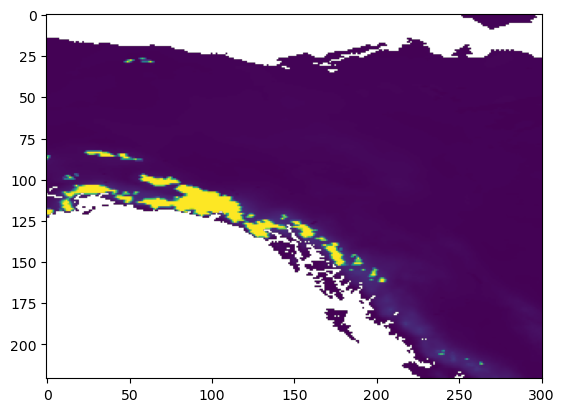

In [9]:
plt.imshow(xda[0,:,:])

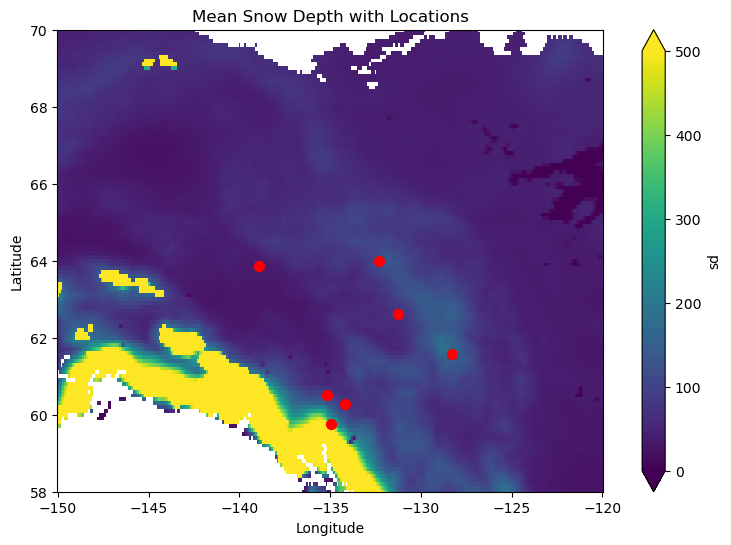

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
locations.plot(ax=ax, color='red', label='Locations', markersize=50)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()

In [11]:
# download all contniuous SWE measurements
ts_ids = timeseries_df.index.tolist()
res = {}

def fetch_timeseries_corrected(ts_id, db_url=db_url):
    engine = create_engine(db_url)
    with engine.connect() as connection:
        out = connection.execute(
            text("SELECT * FROM continuous.measurements_continuous_corrected WHERE timeseries_id IN ({})".format(ts_id))
        )

        timeseries_md = connection.execute(
            text("SELECT * FROM continuous.timeseries WHERE timeseries_id IN ({})".format(ts_id))
        )
        timeseries_md = pd.DataFrame(timeseries_md).squeeze().to_dict()

        parameter_md = connection.execute(
            text("SELECT * FROM public.parameters WHERE parameter_id IN ({})".format(timeseries_md["parameter_id"]))
        )
        parameter_md = pd.DataFrame(parameter_md).squeeze().to_dict()

        out = pd.DataFrame(out).set_index("datetime")["value_corrected"]
        units = parameter_md["unit_default"]
        param = parameter_md["param_name"]
        tag = f"{ts_id}_{param}({units})"
        out.name = tag
        out = out.astype(float)
        out.to_frame()
        
        metadata = {"timeseries": timeseries_md, "parameter": parameter_md}
        return out, metadata

In [12]:
results = {}

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    x, y = locations.loc[loc_id, "geometry"].x, locations.loc[loc_id, "geometry"].y

    era5_ts = xda.sel(longitude=x, latitude=y, method="nearest").to_dataframe().reset_index()
    era5_ts = era5_ts.set_index('time')['sd']

    yg_ts, _ = fetch_timeseries_corrected(ts_id)

    # aggregate to daily before syncing
    yg_ts = yg_ts.resample('D').mean()
    era5_ts = era5_ts.resample('D').mean()

    synced_ts = pd.concat([era5_ts, yg_ts], axis=1, join="outer")
    synced_ts.columns = ["ERA5", "YG"]

    results[ts_id] = synced_ts


In [ ]:
yg_ts.index[1].tz_convert('UTC').tz_localize(None) - pd.Timedelta(hours=7)

Timestamp('1988-10-08 17:00:00')

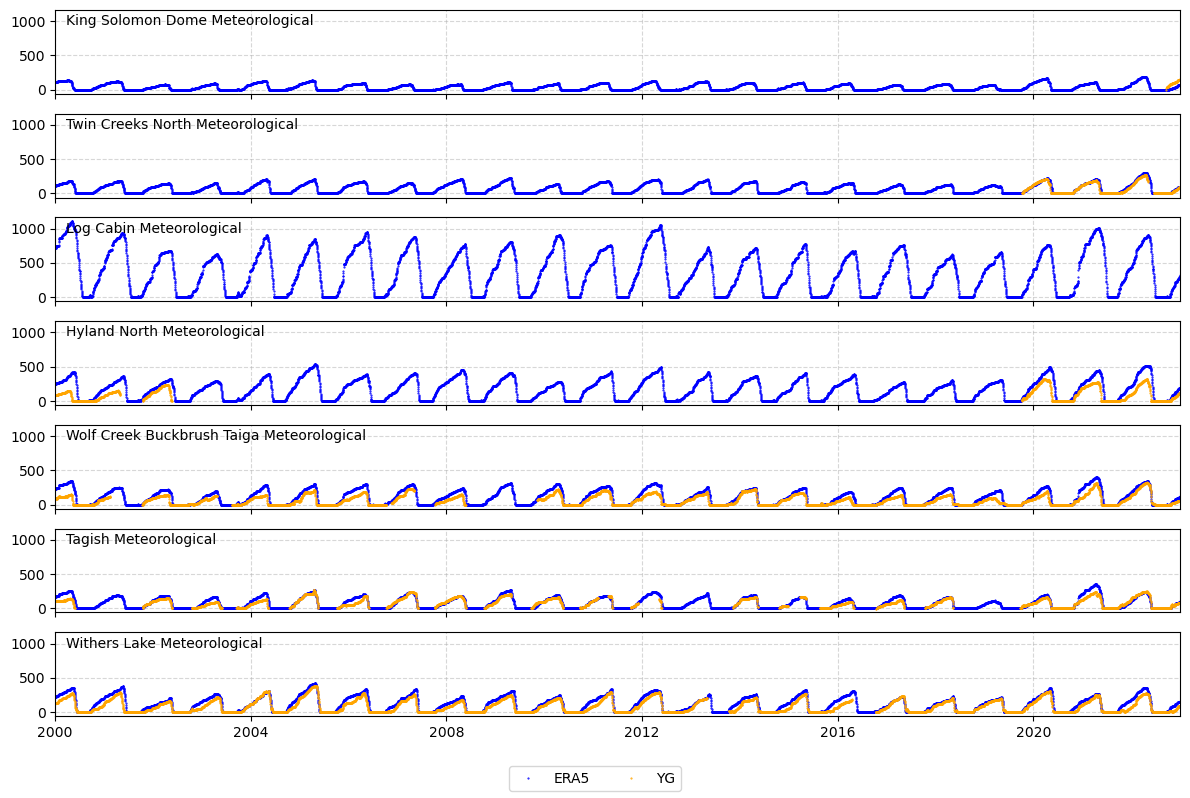

In [29]:
fig, axes = plt.subplots(7, 1, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    ax = axes[i]
    synced_ts = results[ts_id]
    ax.plot(synced_ts.index, synced_ts["ERA5"], label="ERA5", color="blue", marker='.', markersize=1, linestyle='', linewidth=0.5)
    ax.plot(synced_ts.index, synced_ts["YG"], label="YG", color="orange", marker='.', markersize=1, linestyle='', linewidth=0.5)

    # Add location annotation
    ax.text(0.01, 0.95, loc_name, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')

    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2023-01-01"))
    ax.grid(True, linestyle='--', alpha=0.5)

# Add a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for the legend
plt.show()

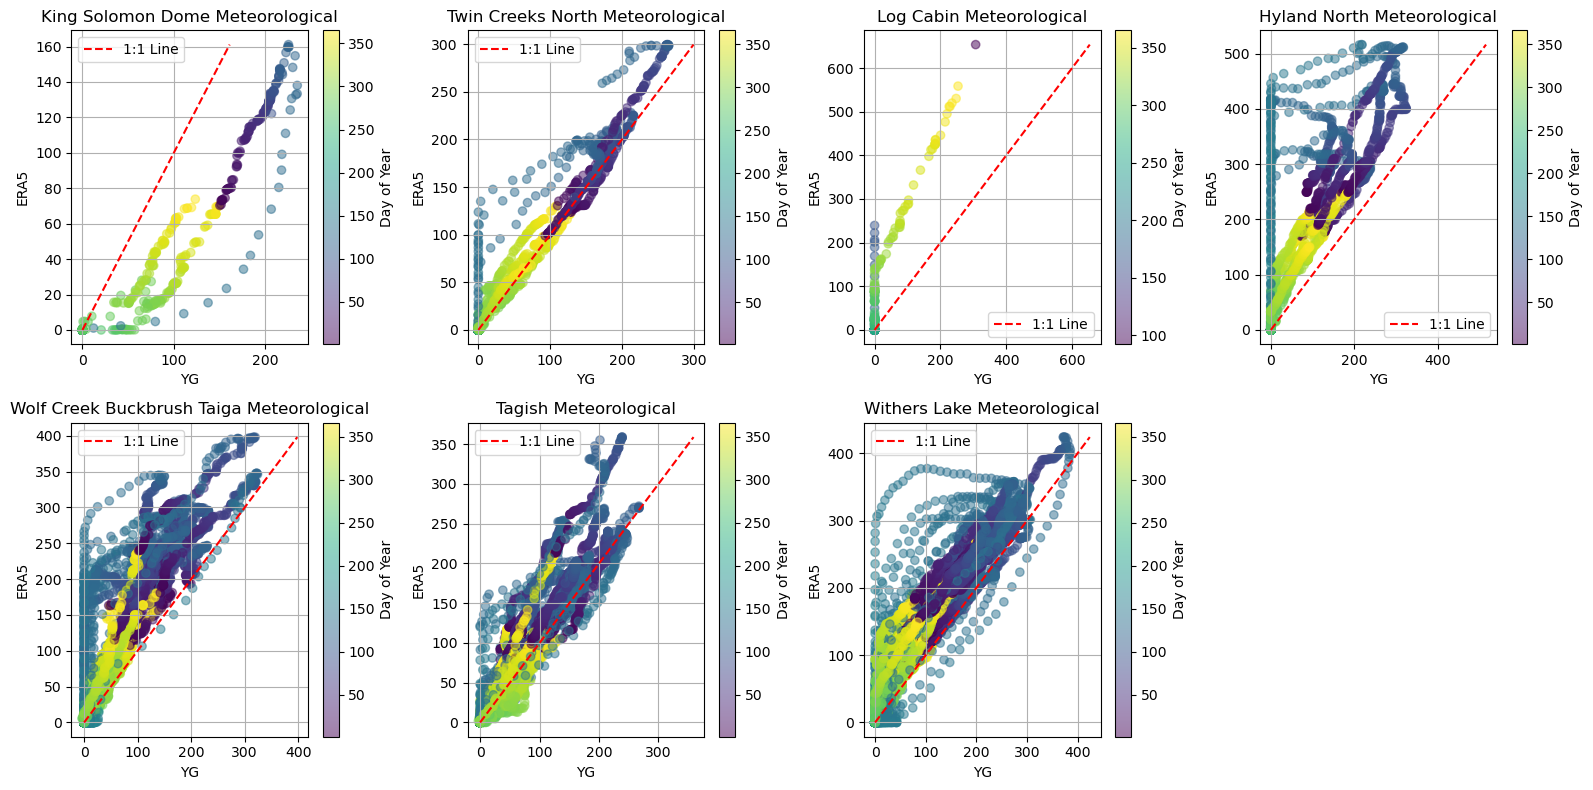

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for ax, (ts_id, data) in zip(axes, results.items()):
    # Drop NaN values for clean comparison
    data = data.dropna()

    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    # Plot 1:1 scatter plot
    scatter = ax.scatter(data["YG"], data["ERA5"], c=data.index.dayofyear, cmap="viridis", alpha=0.5)
    plt.colorbar(scatter, ax=ax, label="Day of Year")
    
    ax.plot([data["ERA5"].min(), data["ERA5"].max()], [data["ERA5"].min(), data["ERA5"].max()], color="red", linestyle="--", label="1:1 Line")

    # Set labels and title
    ax.set_xlabel("YG")
    ax.set_ylabel("ERA5")
    ax.set_title(f"{loc_name}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:

import geopandas as gpd

locations_table = pqc.fetch_locations()

results_table = pqc.fetch_table(table_name="discrete.results").set_index("result_id")

results_table = results_table.loc[results_table["parameter_id"] == 21]

sample_ids = results_table.sample_id.unique()
samples_table = pqc.fetch_table(table_name="discrete.samples").set_index("sample_id")
results_table["location_id"] = samples_table.loc[results_table["sample_id"].values, "location_id"].values

results_table["datetime"] = samples_table.loc[results_table["sample_id"].values, "datetime"].values
results_table["target_datetime"] = samples_table.loc[results_table["sample_id"].values, "target_datetime"].values
results_table["datetime"] = results_table["datetime"].dt.tz_localize("UTC")

results_table["target_datetime"] = results_table["target_datetime"].dt.tz_localize("UTC")

results_table["geometry"] = locations_table.loc[results_table["location_id"].values, "geometry"].values
results_table = gpd.GeoDataFrame(results_table)

In [16]:
results_table

,sample_id,result_type,parameter_id,sample_fraction,result,result_condition,result_condition_value,result_value_type,result_speciation,protocol_method,laboratory,analysis_datetime,share_with,no_update,created,modified,location_id,datetime,target_datetime,geometry
result_id,,,,,,,,,,,,,,,,,,,,
1,1,1,21,None,381.0000000000000000,None,None,1,None,1,None,None,[public_reader],False,2024-10-01 19:56:46.696754+00:00,NaT,46,1960-03-01 19:00:00+00:00,1960-03-01 19:00:00+00:00,POINT (-134.96667 59.76667)
3,2,1,21,None,427.0000000000000000,None,None,1,None,1,None,None,[public_reader],False,2024-10-01 19:56:46.696754+00:00,NaT,46,1960-03-31 19:00:00+00:00,1960-04-01 19:00:00+00:00,POINT (-134.96667 59.76667)
5,3,1,21,None,394.0000000000000000,None,None,1,None,1,None,None,[public_reader],False,2024-10-01 19:56:46.696754+00:00,NaT,46,1960-04-26 19:00:00+00:00,1960-05-01 19:00:00+00:00,POINT (-134.96667 59.76667)
7,4,1,21,None,356.0000000000000000,None,None,1,None,1,None,None,[public_reader],False,2024-10-01 19:56:46.696754+00:00,NaT,46,1961-03-28 19:00:00+00:00,1961-04-01 19:00:00+00:00,POINT (-134.96667 59.76667)
9,5,1,21,None,244.0000000000000000,None,None,1,None,1,None,None,[public_reader],False,2024-10-01 19:56:46.696754+00:00,NaT,46,1961-05-02 19:00:00+00:00,1961-05-01 19:00:00+00:00,POINT (-134.96667 59.76667)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19718,9860,1,21,None,145,None,None,1,None,1,None,None,[public_reader],False,2025-04-02 20:10:37.735003+00:00,NaT,86,2025-03-27 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-131.26236 62.61925)
19720,9861,1,21,None,330,None,None,1,None,1,None,None,[public_reader],False,2025-04-03 18:06:38.894477+00:00,NaT,42,2025-03-31 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-135.25 59.51667)
19722,9862,1,21,None,107,None,None,1,None,1,None,None,[public_reader],False,2025-04-03 18:06:39.052686+00:00,NaT,41,2025-03-31 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-134.53333 58.28333)


In [17]:
engine = create_engine(db_url)
with engine.connect() as connection:
    table_result = connection.execute(
        text(f"SELECT * FROM public.datum_conversions WHERE current = TRUE")
    )
datums_table = pd.DataFrame(table_result)

results_table["datum"] = datums_table.set_index("location_id").loc[results_table["location_id"].values, "conversion_m"].values
results_table["datum"] = results_table["datum"].astype(float)
results_table = results_table.apply(lambda col: pd.to_numeric(col, errors='ignore') if col.name not in ["datetime","target_datetime"] else col)

In [18]:
results_table["era5_result"] = np.nan

for name, row in tqdm(results_table.iloc[:,:].iterrows()):
    x, y = row.geometry.x, row.geometry.y
    dt = row.datetime

    # Even though ERA5 is UTC, the selection result is not localized in UTC
    res = xda.sel(longitude=x, latitude=y, time = dt, method="nearest")
    
    time_diff = dt - pd.Timestamp(res.time.values).tz_localize("UTC")
    time_diff = np.absolute(time_diff.days)

    if time_diff < 3:
        results_table.loc[name, "era5_result"] = res.values
    else:
        results_table.loc[name, "era5_result"] = np.nan


# Calculate the error (difference between observed and ERA5 results)
results_table["error"] = results_table["result"].astype(float) - results_table["era5_result"].astype(float)


0it [00:00, ?it/s]

9854it [00:16, 613.78it/s]


In [19]:

results_table

,sample_id,result_type,parameter_id,sample_fraction,result,result_condition,result_condition_value,result_value_type,result_speciation,protocol_method,...,no_update,created,modified,location_id,datetime,target_datetime,geometry,datum,era5_result,error
result_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,21,NaN,381.000000,NaN,NaN,1,NaN,1,...,False,1727812606696754000,-9223372036854775808,46,1960-03-01 19:00:00+00:00,1960-03-01 19:00:00+00:00,POINT (-134.96667 59.76667),884.0,NaN,NaN
3,2,1,21,NaN,427.000000,NaN,NaN,1,NaN,1,...,False,1727812606696754000,-9223372036854775808,46,1960-03-31 19:00:00+00:00,1960-04-01 19:00:00+00:00,POINT (-134.96667 59.76667),884.0,NaN,NaN
5,3,1,21,NaN,394.000000,NaN,NaN,1,NaN,1,...,False,1727812606696754000,-9223372036854775808,46,1960-04-26 19:00:00+00:00,1960-05-01 19:00:00+00:00,POINT (-134.96667 59.76667),884.0,NaN,NaN
7,4,1,21,NaN,356.000000,NaN,NaN,1,NaN,1,...,False,1727812606696754000,-9223372036854775808,46,1961-03-28 19:00:00+00:00,1961-04-01 19:00:00+00:00,POINT (-134.96667 59.76667),884.0,NaN,NaN
9,5,1,21,NaN,244.000000,NaN,NaN,1,NaN,1,...,False,1727812606696754000,-9223372036854775808,46,1961-05-02 19:00:00+00:00,1961-05-01 19:00:00+00:00,POINT (-134.96667 59.76667),884.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19718,9860,1,21,NaN,145.000000,NaN,NaN,1,NaN,1,...,False,1743624637735003000,-9223372036854775808,86,2025-03-27 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-131.26236 62.61925),886.0,NaN,NaN
19720,9861,1,21,NaN,330.000000,NaN,NaN,1,NaN,1,...,False,1743703598894477000,-9223372036854775808,42,2025-03-31 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-135.25 59.51667),700.0,1800.543823,-1470.543823
19722,9862,1,21,NaN,107.000000,NaN,NaN,1,NaN,1,...,False,1743703599052686000,-9223372036854775808,41,2025-03-31 19:00:00+00:00,2025-04-01 19:00:00+00:00,POINT (-134.53333 58.28333),305.0,637.192749,-530.192749


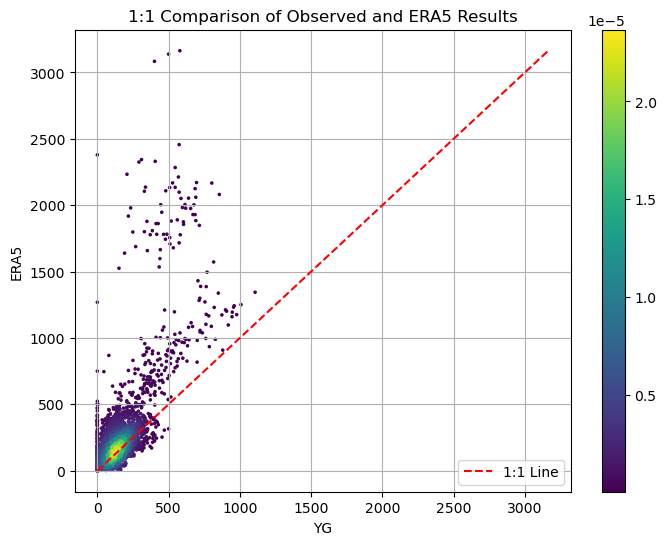

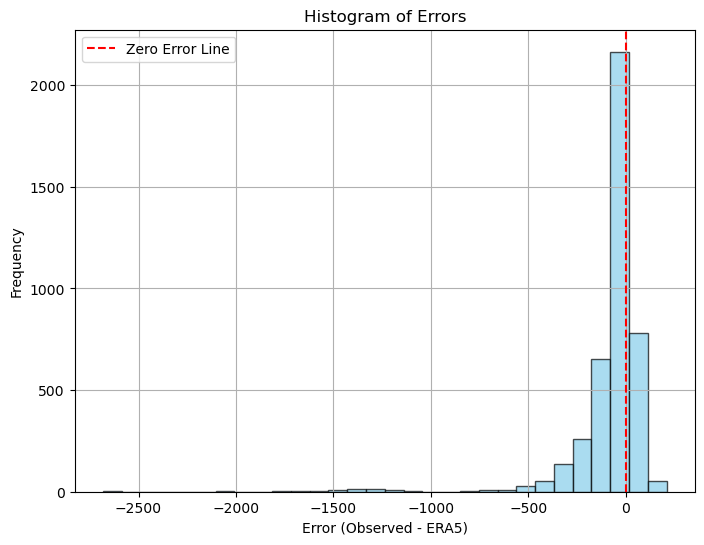

In [20]:
from scipy.stats import gaussian_kde

# Drop rows with NaN values in either 'result' or 'era5_result'
results_table = results_table.dropna(subset=["result", "era5_result"])
results_table["result"] = results_table["result"].astype(float)
results_table["era5_result"] = results_table["era5_result"].astype(float)
# Extract day of year from the datetime column
results_table["day_of_year"] = results_table["datetime"].dt.dayofyear

# Create the 1:1 scatter plot
plt.figure(figsize=(8, 6))


# Scatter plot with colorized markers based on day of year
# Calculate the point density
xy = np.vstack([results_table["result"], results_table["era5_result"]])
z = gaussian_kde(xy)(xy)

# Scatter plot with colorized markers based on density
scatter = plt.scatter(
    results_table["result"],
    results_table["era5_result"],
    c=z,
    cmap="viridis",
    marker='.',
    s=10  # Marker size
)


# Add a colorbar
cbar = plt.colorbar(scatter)

# Add a 1:1 line
min_val = min(results_table["result"].min(), results_table["era5_result"].min())
max_val = max(results_table["result"].max(), results_table["era5_result"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")

# Set plot labels and title
plt.xlabel("YG")
plt.ylabel("ERA5")
plt.title("1:1 Comparison of Observed and ERA5 Results")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plot the histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(results_table["error"], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")

# Set plot labels and title
plt.xlabel("Error (Observed - ERA5)")
plt.ylabel("Frequency")
plt.title("Histogram of Errors")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

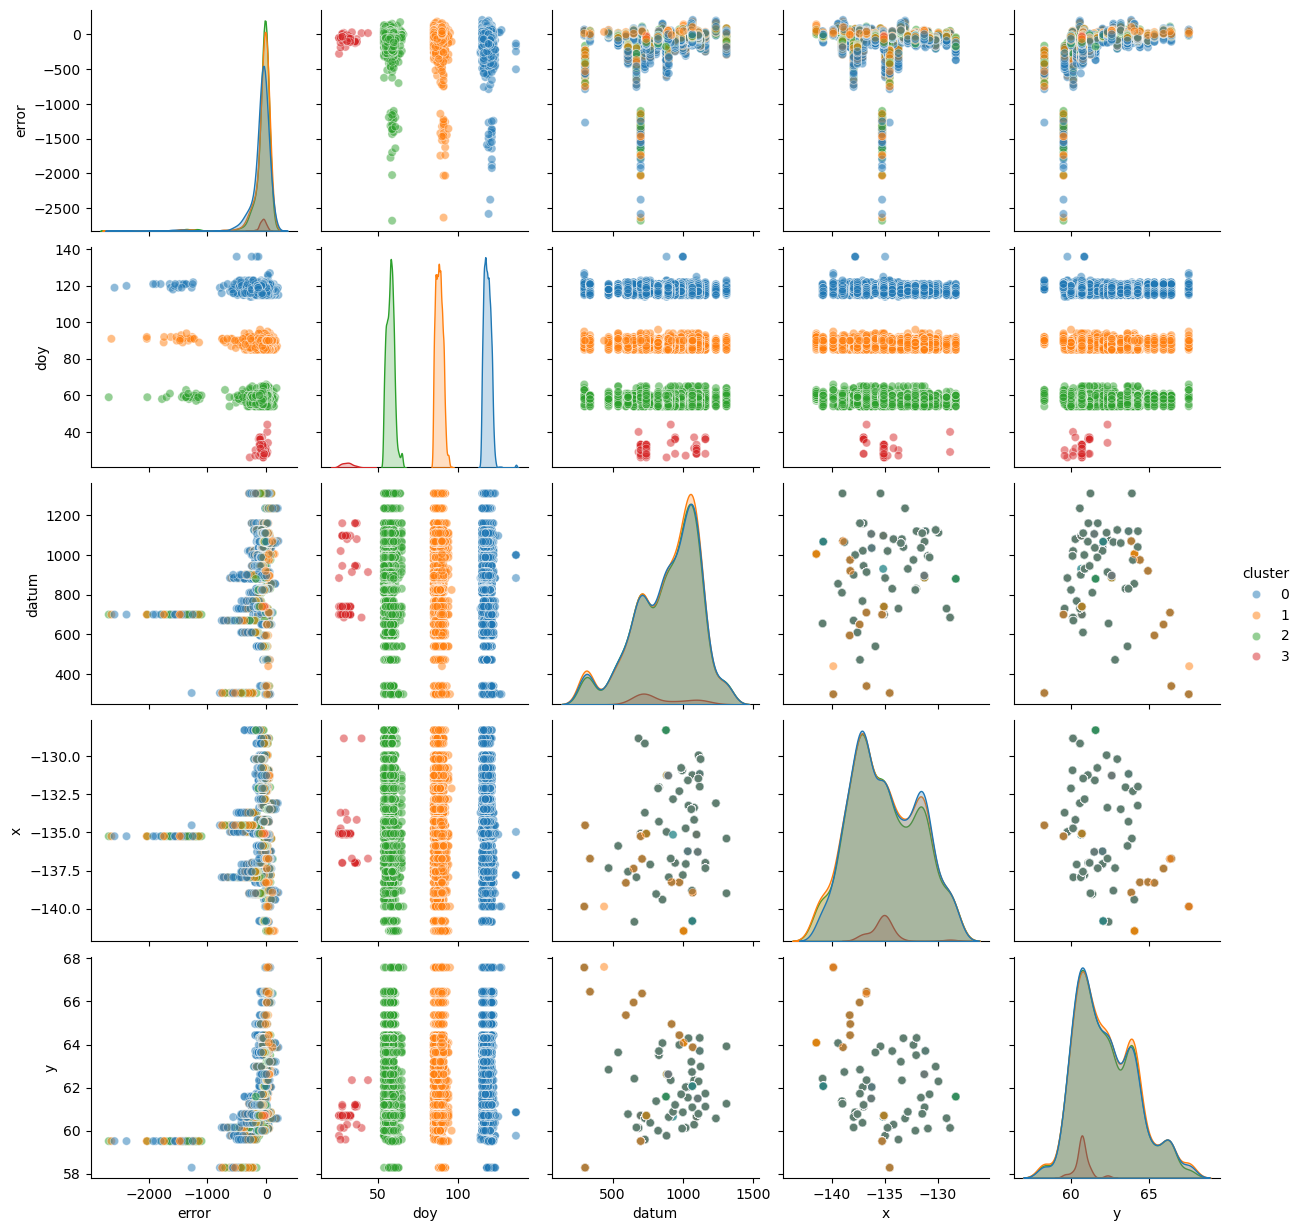

In [21]:
import seaborn as sns
from sklearn.cluster import KMeans
results_table["x"] = results_table.geometry.x
results_table["y"] = results_table.geometry.y
results_table["doy"] = results_table.datetime.dt.dayofyear

# Select numeric columns for the scatterplot matrix
include_columns = ["error","doy","datum","x","y"]

# Perform KMeans clustering on the 'doy' column
kmeans = KMeans(n_clusters=4, random_state=42)
results_table['cluster'] = kmeans.fit_predict(results_table[['doy']])

# Create a scatterplot matrix with hue set to the cluster
sns.pairplot(results_table[include_columns + ['cluster']], diag_kind='kde', hue='cluster', plot_kws={'alpha': 0.5}, palette="tab10")

# Show the plot
plt.show()


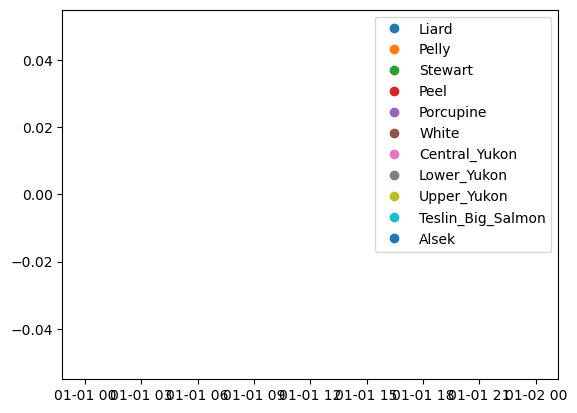

In [22]:
# load and preprocess the snowcourse factors
snowcourse_factors = pd.read_csv(r"C:\Users\esniede\Documents\github\YGwater\data-raw\snowcourse_factors.csv", index_col=1)
snowcourse_factors = snowcourse_factors[snowcourse_factors.index != "10AD-SC01"] # remove duplicate hyland river vaue
snowcourse_factors.drop(columns=["location_name"], inplace=True)

# rename factors based on location ID
renaming_dict = {row["location"]:name for name, row in locations.iterrows()}
snowcourse_factors.index = snowcourse_factors.index.map(renaming_dict)

locations = pqc.fetch_locations(db_url)

snow_survey_dates = results_table["target_datetime"].unique()

basin_avgs = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)

for survey_date in snow_survey_dates:
    
    # copy the weights matrix; we're going to adjust the
    snowcourse_factors_corrected = snowcourse_factors.copy()
    idx = survey_date == results_table["target_datetime"]
    df = results_table.loc[idx,:]

    # get the locations of results available at the survey date
    location_codes = locations.loc[df["location_id"].values, "location"].values
    
    values = []

    # for each sampling location
    for loc, _ in snowcourse_factors_corrected.iterrows():
        idx = df["location_id"] == loc
        # if there are no results for the location, set the value to NaN
        if sum(idx) == 0:
            values.append(np.nan)

        # in the case where there are multiple results for the same location, take the mean of the results
        elif sum(idx) > 0:
            value = df.loc[idx, "result"].mean()
            values.append(value.mean())

    # add dim for matrix multiplication
    values = np.array(values).reshape(-1, 1)
    # set snowcourse factors to 0 if no value is available
    snowcourse_factors_corrected.loc[np.isnan(values).squeeze(),:] = 0
    # normalize for convex combination
    snowcourse_factors_corrected = snowcourse_factors_corrected.div(snowcourse_factors_corrected.sum(axis=0), axis=1)

    # Handle NaNs in values before matrix multiplication (these have a weight of 0, so the values don't matter, just can't be nan for matrix multiplication)
    values[np.isnan(values)] = 0

    # matrix multiplication and store the result in basin_avgs
    basin_avg = snowcourse_factors_corrected.T @ values
    basin_avgs.loc[survey_date, :] = basin_avg.squeeze()

plt.plot(basin_avgs, label=basin_avgs.columns, marker='o', linestyle='')
plt.legend()

In [23]:
results_table.loc[results_table["target_datetime"] == snow_survey_dates[-30]]["location_id"]

result_id
383       46
791       47
1265     158
1743      57
2155     125
2359     146
2713      44
3063      77
3375      96
3693     130
4095     136
4443     137
4799     142
5153     166
5505     110
5969      54
6317      20
6667     100
7013      45
7411     101
7759      66
8103     160
8453     170
8795     177
9131     178
9605      86
9951     102
10605    159
10853     41
11191     87
11449    155
11885    118
12499     21
12807     34
13341    150
13603    151
14035    116
14411    122
14653    182
14901     88
15145     93
15571     78
15805    123
16049     94
16287    127
16521     67
16767     89
17005    161
17239     69
17477    148
17713    126
17879    111
18059     42
18289     22
18467     79
18631     23
18978    319
19492    317
Name: location_id, dtype: int64

In [24]:
from datetime import datetime


latency = 5 # days

# download the most recent SWE data from ERA5
while not success:
    try:
        latest_date = datetime.now() - pd.DateOffset(days=latency)
        era5.download_from_cds(years=[latest_date.year], months=[latest_date.month], days=[latest_date.day], times=range(0, 24))
        success = True
    except Exception as e:
        print(f"Error: {e}")
        latency += 1
        print(f"Retrying with latency of {latency} days...")
        if latency > 30:
            print("Max latency reached. Exiting.")
            break

NameError: name 'success' is not defined

In [ ]:
basin_avg

,0
Liard,233.620000
Pelly,170.414579
Stewart,209.877907
Peel,163.660000
Porcupine,132.000000
White,90.250000
Central_Yukon,107.430000
Lower_Yukon,209.950000
Upper_Yukon,201.797778
Teslin_Big_Salmon,202.594937


Liard                1.0
Pelly                1.0
Stewart              1.0
Peel                 1.0
Porcupine            1.0
White                1.0
Central_Yukon        1.0
Lower_Yukon          1.0
Upper_Yukon          1.0
Teslin_Big_Salmon    1.0
Alsek                1.0
dtype: float64

KeyError: "None of [Index(['10AA-SC03', '10AB-SC01', '10AA-SC01', '10AD-SC01B', '09BA-SC05',\n       '10AA-SC02', '10AA-SC04', '09BA-SC03', '09BC-SC01', '09CD-SC03',\n       '09BA-SC02A', '09BA-SC04', '09BB-SC03', '09DA-SC01', '09DC-SC02',\n       '09DD-SC01', '09DB-SC01', '09DB-SC02', '10MB-SC01', '09DC-SC01A',\n       '09DC-SC01B', '09FA-SC01', '10MA-SC02', '10MA-SC01', '09EA-SC02',\n       '09FB-SC01', '09FB-SC02', '09FD-SC01', '09EA-SC01', '09EB-SC01',\n       '09EC-SC02', '09CA-SC03', '09CD-SC01', '09CB-SC01', '09CB-SC02',\n       '09CA-SC02', '09CA-SC01', '08AB-SC03', '09AE-SC01', '09AH-SC03',\n       '09AH-SC04', '09BB-SC04', '09AA-SC03', '09AA-SC04', '09AH-SC01',\n       '09AA-SC01', '09AA-SC02', '09AD-SC01', '09AD-SC02', '08AK-SC02',\n       '09AB-SC01B', '09AB-SC02B', '08AA-SC01', '08AA-SC03', '08AK-SC01',\n       '08AA-SC02', '08AA-SC04'],\n      dtype='object', name='location_id')] are in the [index]"

AttributeError: 'dict' object has no attribute 'location_id'

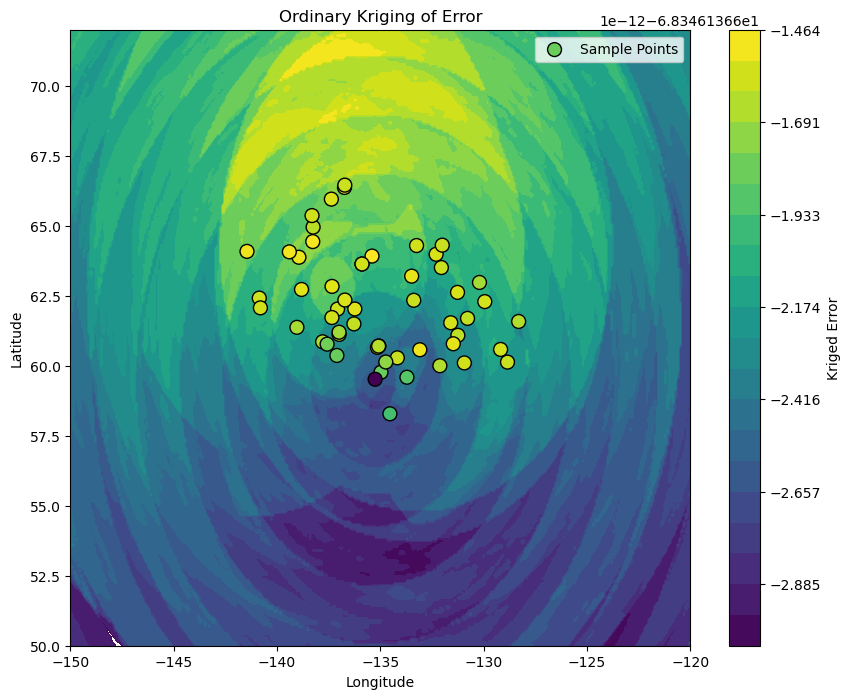

In [ ]:
from pykrige.ok import OrdinaryKriging

# Extract coordinates and the error values
x_coords = df["x"].values
y_coords = df["y"].values
errors = df["error"].values

# Perform ordinary kriging
OK = OrdinaryKriging(
    x_coords, y_coords, errors,
    variogram_model="linear",  # You can also try 'spherical', 'exponential', etc.
    verbose=False,
    enable_plotting=False
)

# Define a grid for interpolation
grid_x = xda.longitude.values
grid_y = xda.latitude.values

grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Interpolate the error values on the grid
z, ss = OK.execute("grid", grid_x, grid_y)

# Plot the kriging result
plt.figure(figsize=(10, 8))
plt.contourf(grid_xx, grid_yy, z, cmap="viridis", levels=20)
plt.colorbar(label="Kriged Error")
plt.scatter(x_coords, y_coords, c=errors, cmap="viridis", edgecolor="k", label="Sample Points", s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ordinary Kriging of Error")
plt.legend()
plt.show()


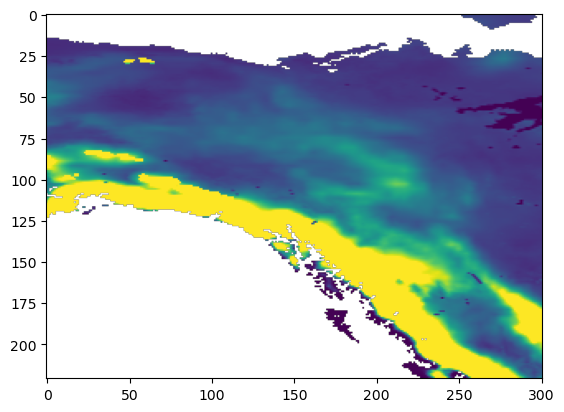

In [ ]:
plt.imshow(xda.sel(time=day).values, vmin=0, vmax=500, cmap="viridis")


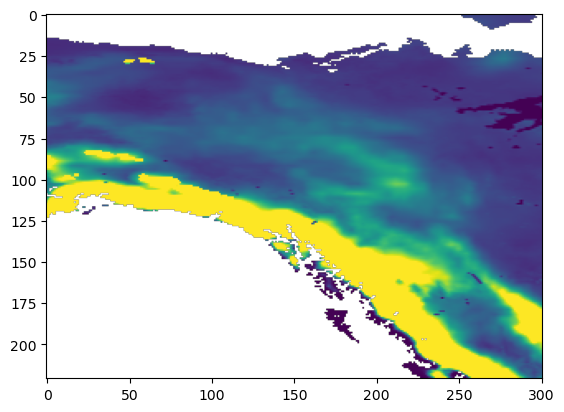

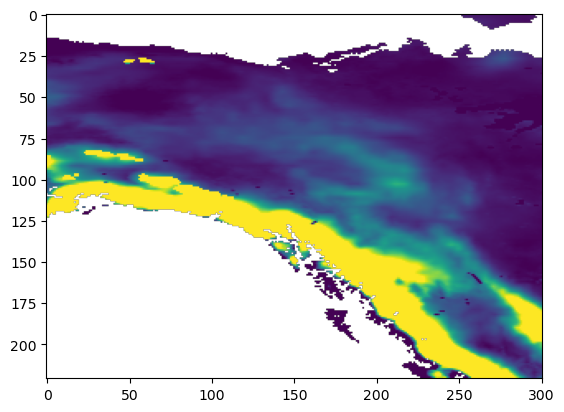

In [ ]:
plt.imshow(xda.sel(time=day).values + z, vmin=0, vmax=500, cmap="viridis")

In [ ]:
from pyquacache.utils.spatialutils import poly_to_mask

masks = poly_to_mask(reference_data=xda, poly=gdf)


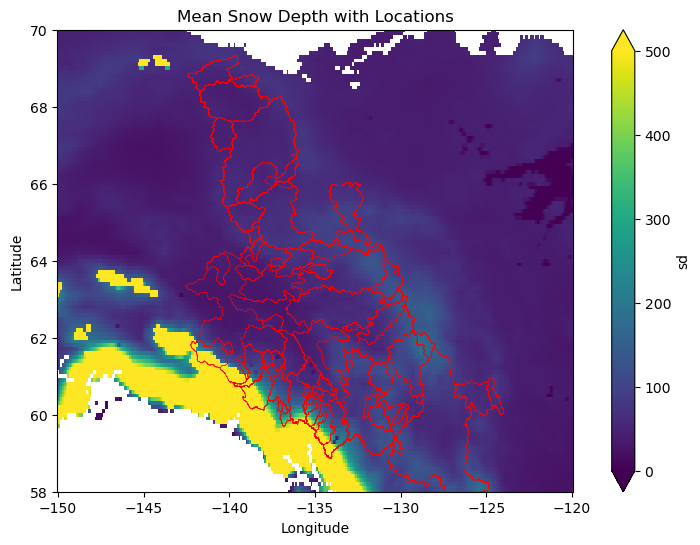

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
gdf.plot(ax=ax, color="None", edgecolor="red", label='Locations', linewidth=0.4)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()

In [ ]:
df = pd.DataFrame(index=xda.time.values, columns=gdf.index)
for dt in xda.time.values:
    for key, mask in masks.items():
        sampled_values = xda.sel(time=dt).where(mask)
        df.loc[dt, key] = sampled_values.mean().values
df = df.astype(float)



<Axes: >

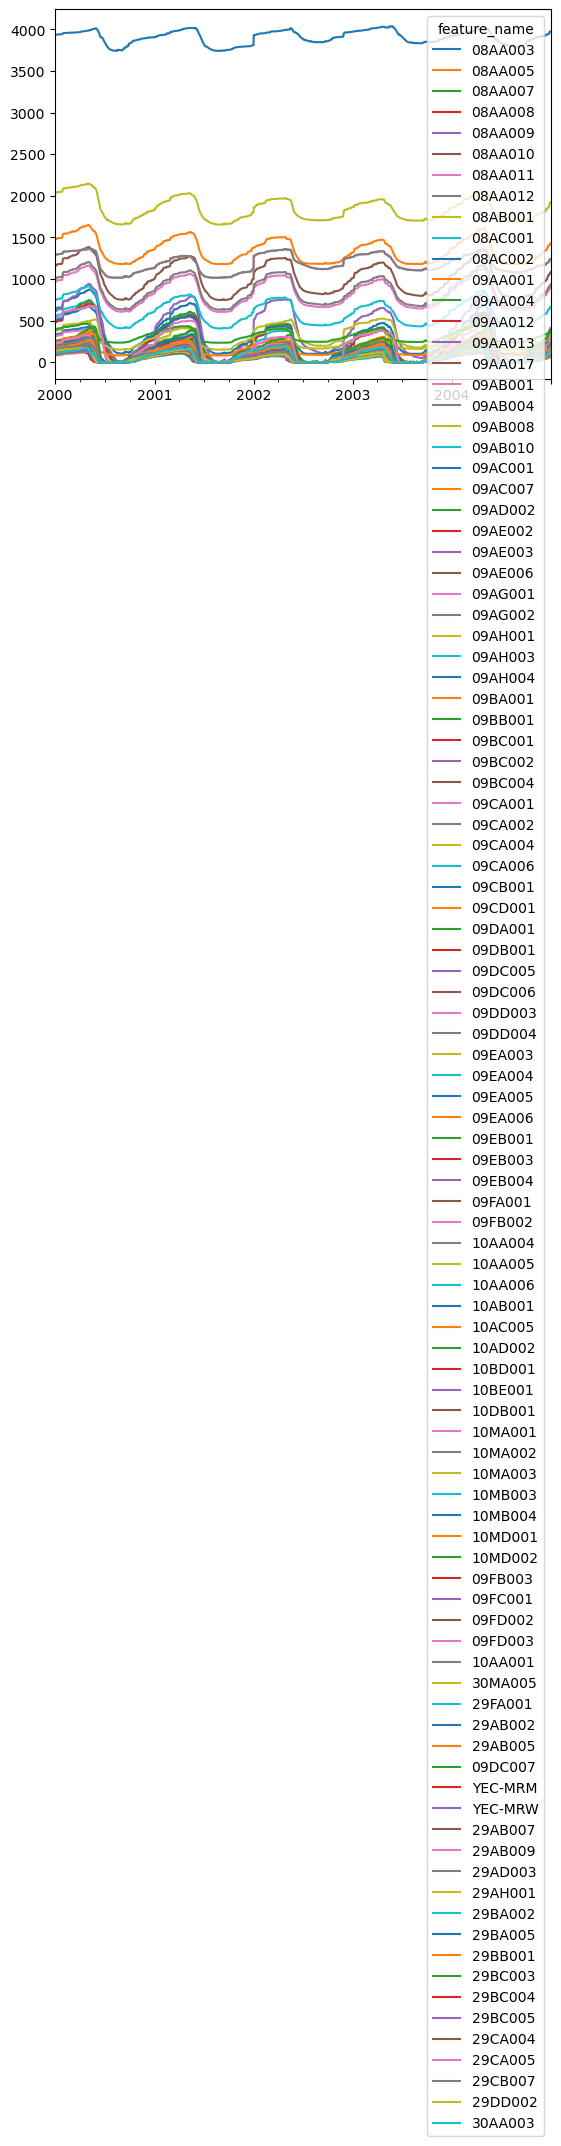

In [ ]:
df.plot()

<Axes: >

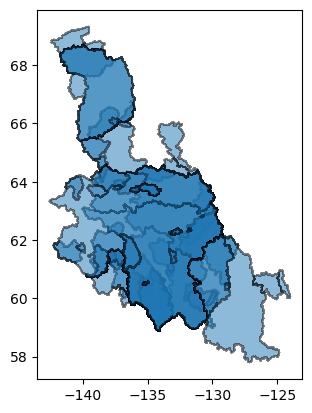

In [ ]:
gdf.plot(facecolor=None, edgecolor="black", alpha=0.5)

In [ ]:
len(masks)

100

AttributeError: 'dict' object has no attribute 'ites'

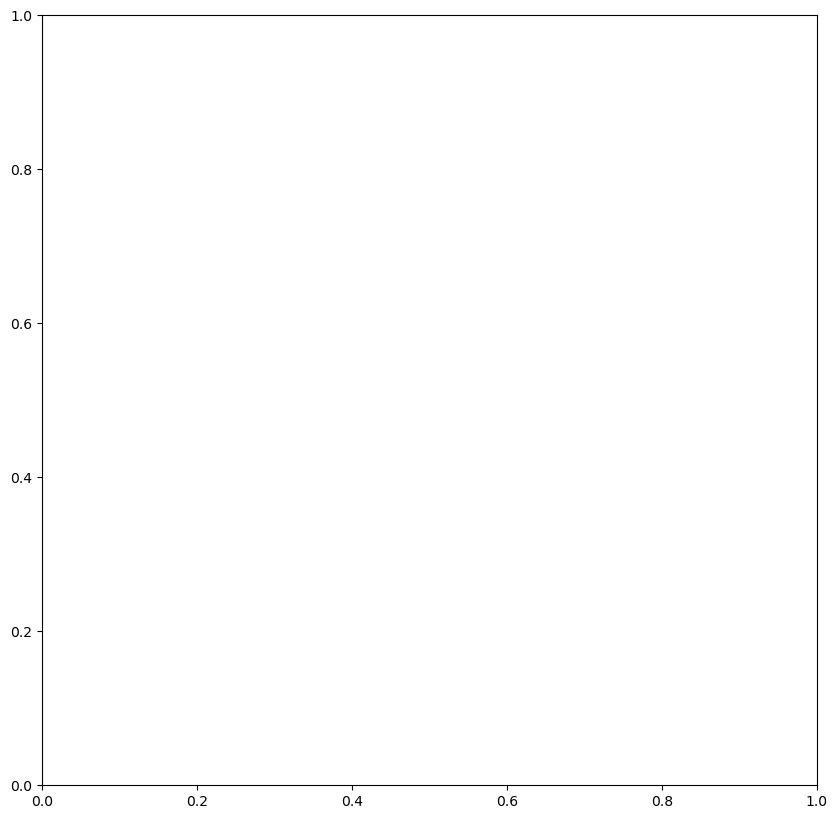

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a single axis

# Iterate through masks and plot each one
for key, mask in masks.ites():
    ax.imshow(mask, cmap='Greens', alpha=0.5, interpolation='none', label=key)

# Add a legend
ax.legend(loc='upper right', fontsize='small', title='Masks')

# Set title and turn off axes
ax.set_title("Combined Masks")

plt.tight_layout()
plt.show()

In [ ]:
masks

{'08AA003': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '08AA005': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '08AA007': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fal